# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

## Решение

Импортируем основные библиотеки здесь, а далее по мере надобности. Это работа с данными и визуализация.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Загрузим данные с эксель файла и проверим их на пропуски, типы данных и по статистическим мтерикам.

In [2]:
data = pd.read_excel('geo.xlsx')

In [3]:
data.head()

,Unnamed: 0,x,y,comment_class
0,0,37.612416,55.777454,-1
1,1,37.612416,55.777454,-1
2,2,37.603298,55.742108,-1
3,3,37.558526,55.728758,-1
4,4,37.566431,55.731794,-1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108806 entries, 0 to 108805
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     108806 non-null  int64  
 1   x              108806 non-null  float64
 2   y              108806 non-null  float64
 3   comment_class  108806 non-null  int64  
dtypes: float64(2), int64(2)
memory usage: 3.3 MB


In [5]:
data.describe()

,Unnamed: 0,x,y,comment_class
count,108806.000000,108806.000000,108806.000000,108806.000000
mean,54402.500000,37.567532,55.766346,-0.748929
std,31409.731032,0.121996,0.069622,0.662653
min,0.000000,37.148813,55.496939,-1.000000
25%,27201.250000,37.454528,55.729797,-1.000000
50%,54402.500000,37.559640,55.764734,-1.000000
75%,81603.750000,37.684784,55.806869,-1.000000
max,108805.000000,37.931228,55.994174,1.000000


Видно, что данные численные типы целочисленные и с плавающей точкой. По статистическим данным смотреть бесполезно, из-за смысла данных - это координаты точек в городе и голоса - за/против. Однако можем увидеть границы города по минимуму и максимуму координат. А также проверить на наличие выбросов.

"Начертим" карту города по координатам и уберём лишний столбец порядковый номер.

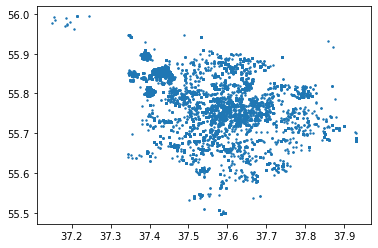

In [6]:
plt.scatter(data['x'], data['y'], cmap= 'yellow', s=2)
plt.show()

In [15]:
data_tr = data.iloc[:, 1:3]
data_tr.head()

,x,y
0,37.612416,55.777454
1,37.612416,55.777454
2,37.603298,55.742108
3,37.558526,55.728758
4,37.566431,55.731794


В задаче класстеризации районов города будем использовать классическую библиотеку кластеризации, а метода попробуем три:  KMeans, AgglomerativeClustering, DBSCAN и проверим их работу в данной задаче. Также используем метрики качества данных: adjusted_rand_score, silhouette_score.

In [9]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import adjusted_rand_score, silhouette_score

### Кластеризация при помощи Kmeans

Определим для начала оптимальное количество кластеров в Kmeans, построив характеристику: зависимость количества класстеров от инерции Kmeans(сумма квадратов расстоний до ближайших цетров кластеров). Возьмём точку на изгибе "локтя".

In [16]:
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(data_tr, )
    k_inertia.append(clf_kmeans.inertia_)

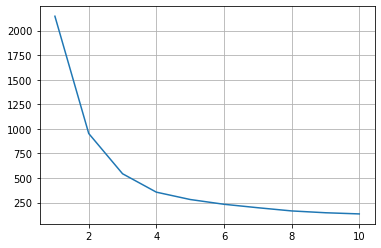

In [17]:
plt.plot(ks, k_inertia)
plt.grid()

In [18]:
diff = np.diff(k_inertia)

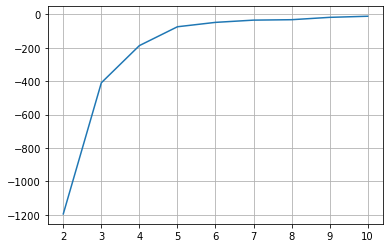

In [19]:
plt.plot(ks[1:], diff)
plt.grid()

In [20]:
diff_r = diff[1:] / diff[:-1]
diff_r

array([0.34315678, 0.45756579, 0.3989494 , 0.64907408, 0.7237972 ,
       0.92740575, 0.56844691, 0.64186418])

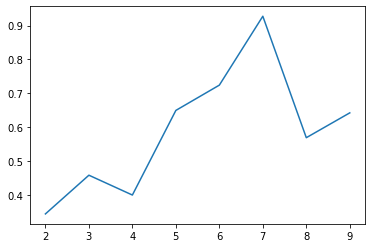

In [21]:
plt.plot(ks[1:-1], diff_r)

В данном случае по характеристике была выбрана точка clusters = 4

In [16]:
alg1 = KMeans(n_clusters=4)

In [17]:
alg1.fit_predict(data_tr)

array([0, 0, 0, ..., 1, 1, 1])

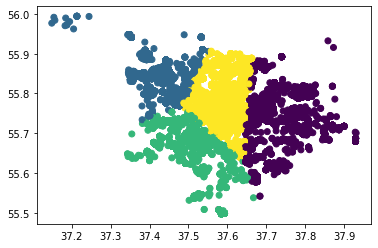

In [18]:
plt.scatter(data_tr['x'],data_tr['y'], c=alg1.fit_predict(data_tr))

In [19]:
silhouette_score(data_tr, alg1.labels_)

0.533991202090518

Итого, алгоритм Kmeans неплохо показал разделение на 4 района города. Видно, что дальние точки районов принадлжедат нужным районам.

### Hierarchical clustering

Попробуем следующий алгоритм кластеризации и построим визуализацию к нему.

In [3]:
from scipy.cluster.hierarchy import dendrogram

In [4]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

In [5]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1 
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)


In [24]:
alg20 = AgglomerativeClustering(distance_threshold=0, n_clusters=None,  linkage='single')

dend_m0 = alg20.fit(data_tr)
scat_m0 = alg20.fit_predict(data_tr)

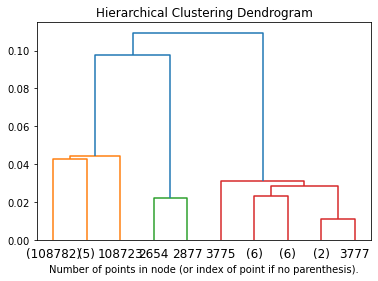

In [25]:
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(dend_m0, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

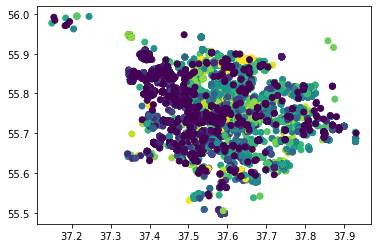

In [26]:
plt.scatter(data_tr['x'],data_tr['y'], c=scat_m0)

In [27]:
alg2 = AgglomerativeClustering( n_clusters=4,  linkage='single')

dend_m = alg2.fit(data_tr)
scat_m = alg2.fit_predict(data_tr)

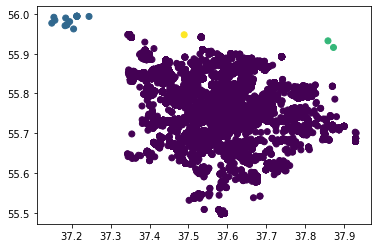

In [28]:
plt.scatter(data_tr['x'],data_tr['y'], c=scat_m)

In [29]:
alg2.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [30]:
silhouette_score(data_tr, alg2.labels_)

0.10033947400116283

Итого, для данной задачи алгоритм достаточно плохо справляется по сравнению с тем же Kmeans. Видно, что на визуализации полный хаос.

### DBSCAN

In [31]:
alg3 = DBSCAN(eps=0.1)

In [32]:
data_tr_dbscan = data_tr.iloc[:10000, :]

In [33]:
m = alg3.fit(data_tr_dbscan)

In [34]:
m1 = alg3.fit_predict(data_tr_dbscan)

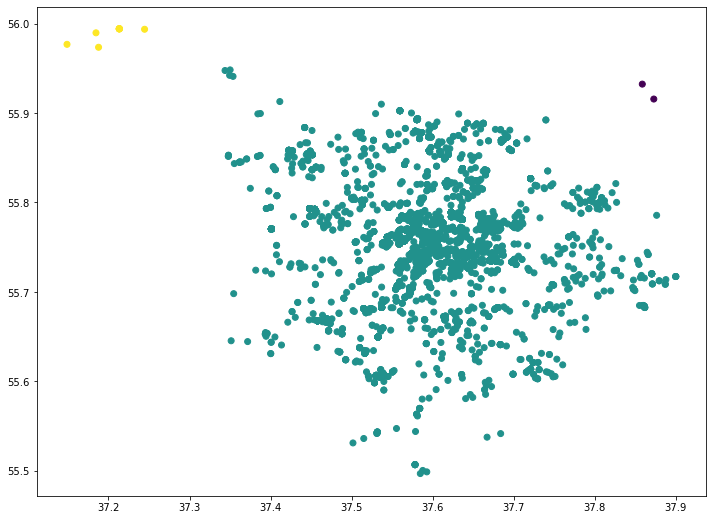

In [35]:
plt.figure(figsize=(12,9))
plt.scatter(data_tr_dbscan['x'], data_tr_dbscan['y'], c=m1)
plt.show()

In [36]:
alg30 = DBSCAN(eps=0.05)

In [37]:
m0 = alg30.fit(data_tr_dbscan)

In [38]:
m10 = alg30.fit_predict(data_tr_dbscan)

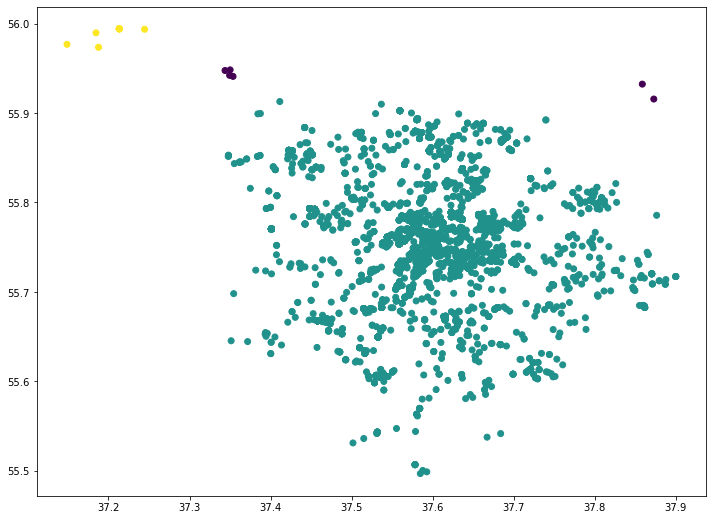

In [39]:
plt.figure(figsize=(12,9))
plt.scatter(data_tr_dbscan['x'], data_tr_dbscan['y'], c=m10)
plt.show()

In [40]:
silhouette_score(data_tr_dbscan, alg3.labels_)

0.7641312350650169

In [41]:
silhouette_score(data_tr_dbscan, alg30.labels_)

0.7721946295403449

Итого, по DBSCAN также как и в предыдущем алгоритме видем, что не очень хорош для поставленной задачи разделения по районам города, либо все точки будут в одном кластере, либо будут выделены в районы отдельно стоящие клочки в районы города, что вцелом имеет место быть, если бы была карта города можно было бы проверить и сказать наверняка, что хорошо, а что плохо. 

### Кластеризация по голосам

Следующая задача кластеризация города по голосам, так как на основании предыдущей задачи лучше всего себя показал алгоритм Kmeans, то буду использовать именно его. Видоимзеним немного датасет с добавлением информации по голосам. 

In [6]:
data_voice = data.iloc[:, 1:4]
data_voice.head()

,x,y,comment_class
0,37.612416,55.777454,-1
1,37.612416,55.777454,-1
2,37.603298,55.742108,-1
3,37.558526,55.728758,-1
4,37.566431,55.731794,-1


Знаем, что будет всего два кластера: за/против. Однако интересно посмотреть на "локоть" по оптимальному количеству кластеров.

In [10]:
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(data_voice, )
    k_inertia.append(clf_kmeans.inertia_)

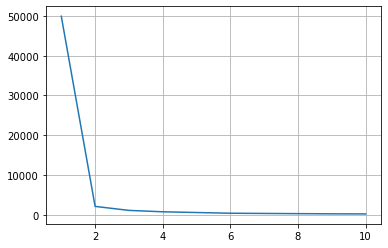

In [11]:
plt.plot(ks, k_inertia)
plt.grid()

In [12]:
algor1 = KMeans(n_clusters=2)

In [13]:
algor1_p = algor1.fit_predict(data_voice)

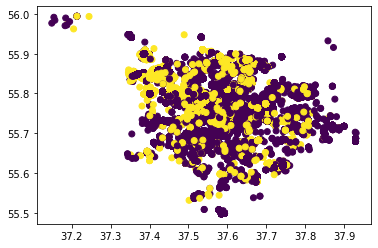

In [14]:
plt.scatter(data_voice['x'], data_voice['y'], c=algor1_p)
plt.show()

In [15]:
print('Silhoutte : ', silhouette_score(data_voice, algor1.labels_))
print('ARI : ', adjusted_rand_score(data_voice['comment_class'], algor1.labels_))

Silhoutte :  0.9150349810289268
ARI :  1.0


Итого, исходя из карты города и по метрикам, видно, что алгоритм отработал хорошо.